In [1]:
import numpy as np
from scipy.stats import iqr
import dill
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import data_visualization as dv
import copy
import numba as nb
import time

import read_data_functions as rdf
import plot_functions as pf
from initializer import InitialThangs
from pathlib import Path
from Subject_Object_v3 import perc

np.set_printoptions(precision=3)
'''


'''

'\n\n\n'

In [2]:
from Optimal_Stopping_Object import ModelConstructor, ModelFitting

%load_ext autoreload
%autoreload 2 


# Notebook Description

README!!

I'm doing 4 different versions

- Loss Function = Median Movement Onset Time or MMOT + SD Movement Onset Time

- Switch        = Guess Delay or Guess Delay + SD Movement Onset Time

# Initial Thangs


In [3]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# SELECT EXPERIMENT
experiment = "Exp1"

# Get path and save path 
LOAD_PATH = Path(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
it = InitialThangs(experiment)

# Pickle Data


In [4]:
if 'group' not in locals():
    group = rdf.generate_subject_object_v3(experiment,)

# Create Models


### Set inputs for model

In [5]:
if experiment == "Exp1":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.reaction_times, axis=1)) - 25
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=1))

elif experiment == "Exp2":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only'), axis=1)) - 30
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.movement_metrics.movement_times('task'), axis=2), axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.movement_metrics.movement_times('task'), axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.movement_metrics.coincidence_reach_time, axis=1))] * it.num_blocks)
perc_wins_both_reach = np.nanmean(group.score_metrics.wins_when_both_reach(perc=True), axis=0)
guess_sd             = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'), axis=2), axis=0)
agent_sds            = np.nanmean(np.nanstd(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
agent_means          = np.nanmean(np.nanmean(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
guess_leave_time_sd  = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'),axis=2),axis=0)

#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward = 1.0
indecision_cost = 0.0
incorrect_cost = 0.0


### Set the model fitting parameters

In [6]:
free_params_init_no_sd = {
        "guess_switch_delay": 0,
    }
behavior_targets_no_sd = np.array(
    [
        np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
    ]
)

behavior_metric_keys_no_sd = ["wtd_leave_time"]


free_params_init_with_sd = {
        "guess_switch_delay": 0,
        "guess_switch_sd": 0,
    }

behavior_targets_with_sd = np.array(
    [
        np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
        np.nanmedian(iqr(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
    ]
)

behavior_metric_keys_with_sd = ["wtd_leave_time","wtd_leave_time_iqr"]

In [7]:
run_numba_quickly = ModelConstructor(
     experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=5,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds= agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd  =np.array([rt_sd, rt_sd]),
    movement_sd  =np.array([mt_sd, mt_sd]), 
    timing_sd    =np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[0, 0]]).T, # Designed like this for broadcasting reasons
    guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    switch_cost_exists=False,
    expected=False,
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)

### Run model without switch cost

In [8]:
# Switch cost is the switch delay and the switch sd
# In this case we 
model_no_switch  = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds= agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd  =np.array([rt_sd, rt_sd]),
    movement_sd  =np.array([mt_sd, mt_sd]),
    timing_sd    =np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[0, 0]]).T, # Designed like this for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    guess_switch_sd=np.array([[0, 0]]).T,

    electromechanical_delay=np.array([[50, 50]]).T,

    expected=False,
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)


### Known, No SD Loss, No SD Model

In [9]:
# * Run true model and fit the guess delay
model_known_switch_sd_neither = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[75, 0]]).T, # Designed like this (2,1) array for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    guess_switch_sd=np.array([[20, 0]]).T,
    expected=False,  # Aka we run the model if they EXPECT no guess switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_known_switch_sd_neither.inputs.guess_switch_delay)
if True:
    model_fit_object_known = ModelFitting(model=model_known_switch_sd_neither)
    res = model_fit_object_known.run_model_fit_procedure(
        free_params_init=free_params_init_no_sd,
        targets=behavior_targets_no_sd,
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=behavior_metric_keys_no_sd,
        bnds=None,
        tol=0.000000001,
        method="brute",
    )
    print(f"Switch Delay: {model_known_switch_sd_neither.inputs.guess_switch_delay[0]}")

[[75]
 [ 0]]
Switch Delay: [20]


### Known, No SD Loss, SD Fit Model

In [10]:
# * Run true model and fit the guess delay
model_known_switch_sd_fit = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[75, 0]]).T, # Designed like this for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    guess_switch_sd=np.array([[0, 0]]).T,

    expected=False,  # Aka we run the model if they EXPECT no guess switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_known_switch_sd_fit.inputs.guess_switch_delay)
if True:
    model_fit_object_known = ModelFitting(model=model_known_switch_sd_fit)
    res = model_fit_object_known.run_model_fit_procedure(
        free_params_init=free_params_init_with_sd, #! sd should be in the free params
        targets=behavior_targets_no_sd,
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=behavior_metric_keys_no_sd, #! sd should NOT be in the loss function
        bnds=None, 
        tol=0.000000001,
        method="brute",
    )
    print(f"Switch Delay: {model_known_switch_sd_fit.inputs.guess_switch_delay[0]}")

[[75]
 [ 0]]
Switch Delay: [30]


### Known, SD loss, NO SD FIT Model

In [11]:
# * Run true model and fit the guess delay
model_known_switch_sd_loss = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[75, 0]]).T, # Designed like this for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    guess_switch_sd=np.array([[0, 0]]).T,

    expected=False,  # Aka we run the model if they EXPECT no guess switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_known_switch_sd_loss.inputs.guess_switch_delay)
if True:
    model_fit_object_known = ModelFitting(model=model_known_switch_sd_loss)
    res = model_fit_object_known.run_model_fit_procedure(
        free_params_init=free_params_init_no_sd, #! sd should NOT be in the fitting
        targets=behavior_targets_with_sd, #! sd should be in the loss function
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=behavior_metric_keys_with_sd, #! sd should be in the loss function
        bnds=None, 
        tol=0.000000001,
        method="brute",
    )
    print(f"Switch Delay: {model_known_switch_sd_loss.inputs.guess_switch_delay[0]}")

[[75]
 [ 0]]
Switch Delay: [15]


### Known, SD loss, SD FIT Model

In [12]:
# * Run true model and fit the guess delay
model_known_switch_sd_both = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[75, 0]]).T, # Designed like this for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    guess_switch_sd=np.array([[0, 0]]).T,

    expected=False,  # Aka we run the model if they EXPECT no guess switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_known_switch_sd_both.inputs.guess_switch_delay)
if True:
    model_fit_object_known = ModelFitting(model=model_known_switch_sd_both)
    res = model_fit_object_known.run_model_fit_procedure(
        free_params_init=free_params_init_with_sd, #! sd should be in the parameter fits
        targets=behavior_targets_with_sd,
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=behavior_metric_keys_with_sd, #! sd should be in the loss function
        bnds=None, 
        tol=0.000000001,
        method="brute",
    )
    print(f"Switch Delay: {model_known_switch_sd_both.inputs.guess_switch_delay[0]}")

[[75]
 [ 0]]
Switch Delay: [15]


### Unknown, No SD Loss, No SD Model

In [13]:
# * Run true model and fit the guess delay
model_unknown_switch_sd_neither = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[75, 0]]).T, # Designed like this for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    guess_switch_sd=np.array([[20, 0]]).T,

    expected=True,  # Aka we run the model if they EXPECT no guess switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_unknown_switch_sd_neither.inputs.guess_switch_delay)
if True:
    model_fit_object_known = ModelFitting(model=model_unknown_switch_sd_neither)
    res = model_fit_object_known.run_model_fit_procedure(
        free_params_init=free_params_init_no_sd,
        targets=behavior_targets_no_sd,
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=behavior_metric_keys_no_sd,
        bnds=None,
        tol=0.000000001,
        method="brute",
    )
    print(f"Switch Delay: {model_unknown_switch_sd_neither.inputs.guess_switch_delay[0]}")

[[75]
 [ 0]]
Switch Delay: [160]


### UnKnown, No SD Loss, SD Fit Model

In [14]:
# * Run true model and fit the guess delay
model_unknown_switch_sd_fit = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[75, 0]]).T, # Designed like this for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    guess_switch_sd=np.array([[20, 0]]).T,

    expected=True,  # Aka we run the model if they EXPECT no guess switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_unknown_switch_sd_fit.inputs.guess_switch_delay)
if True:
    model_fit_object_known = ModelFitting(model=model_unknown_switch_sd_fit)
    res = model_fit_object_known.run_model_fit_procedure(
        free_params_init=free_params_init_with_sd,
        targets=behavior_targets_no_sd,
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=behavior_metric_keys_no_sd,
        bnds=None,
        tol=0.000000001,
        method="brute",
    )
    print(f"Switch Delay: {model_unknown_switch_sd_fit.inputs.guess_switch_delay[0]}")

[[75]
 [ 0]]
Switch Delay: [160]


### UnKnown, SD loss, No SD FIT Model

In [15]:
# * Run true model and fit the guess delay
model_unknown_switch_sd_loss = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[75, 0]]).T, # Designed like this for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    guess_switch_sd=np.array([[0, 0]]).T,

    expected=True,  # Aka we run the model if they EXPECT no guess switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_unknown_switch_sd_loss.inputs.guess_switch_delay)
if True:
    model_fit_object_known = ModelFitting(model=model_unknown_switch_sd_loss)
    res = model_fit_object_known.run_model_fit_procedure(
        free_params_init=free_params_init_no_sd, #! sd should be in the parameter fits
        targets=behavior_targets_with_sd,
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=behavior_metric_keys_with_sd, #! sd should be in the loss function
        bnds=None, 
        tol=0.000000001,
        method="brute",
    )
    print(f"Switch Delay: {model_unknown_switch_sd_loss.inputs.guess_switch_delay[0]}")

[[75]
 [ 0]]
Switch Delay: [160]


### Unknown SD loss, SD Fit Model

In [16]:
# * Run true model and fit the guess delay
model_unknown_switch_sd_both = ModelConstructor(
    experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd=np.array([rt_sd, rt_sd]),
    movement_sd=np.array([mt_sd, mt_sd]),
    timing_sd=np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[75, 0]]).T, # Designed like this for broadcasting reasons
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50, 50]]).T,
    guess_switch_sd=np.array([[0, 0]]).T,

    expected=True,  # Aka we run the model if they EXPECT no guess switch
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)
print(model_unknown_switch_sd_both.inputs.guess_switch_delay)
if True:
    model_fit_object_known = ModelFitting(model=model_unknown_switch_sd_both)
    res = model_fit_object_known.run_model_fit_procedure(
        free_params_init=free_params_init_with_sd, #! sd should be in the parameter fits
        targets=behavior_targets_with_sd,
        drop_condition_from_loss=None,  # Drop 1200 50
        metric_keys=behavior_metric_keys_with_sd, #! sd should be in the loss function
        bnds=None, 
        tol=0.000000001,
        method="brute",
    )
    print(f"Switch Delay: {model_unknown_switch_sd_both.inputs.guess_switch_delay[0]}")

[[75]
 [ 0]]
Switch Delay: [160]


# Plots

In [17]:
save = False
known_model_labels = ['SD No Fit+Loss\n(Known)','SD Fit+Loss\n(Known)','SD Fit Only\n(Known)', 'SD Loss Only\n(Known)']
unknown_model_labels = ['SD No Fit+Loss\n(Unknown)','SD Fit+Loss\n(Unknown)','SD Fit Only\n(Unknown)', 'SD Loss Only\n(Unknown)']
all_model_labels = known_model_labels+unknown_model_labels

In [18]:
all_model_labels

['SD No Fit+Loss\n(Known)',
 'SD Fit+Loss\n(Known)',
 'SD Fit Only\n(Known)',
 'SD Loss Only\n(Known)',
 'SD No Fit+Loss\n(Unknown)',
 'SD Fit+Loss\n(Unknown)',
 'SD Fit Only\n(Unknown)',
 'SD Loss Only\n(Unknown)']

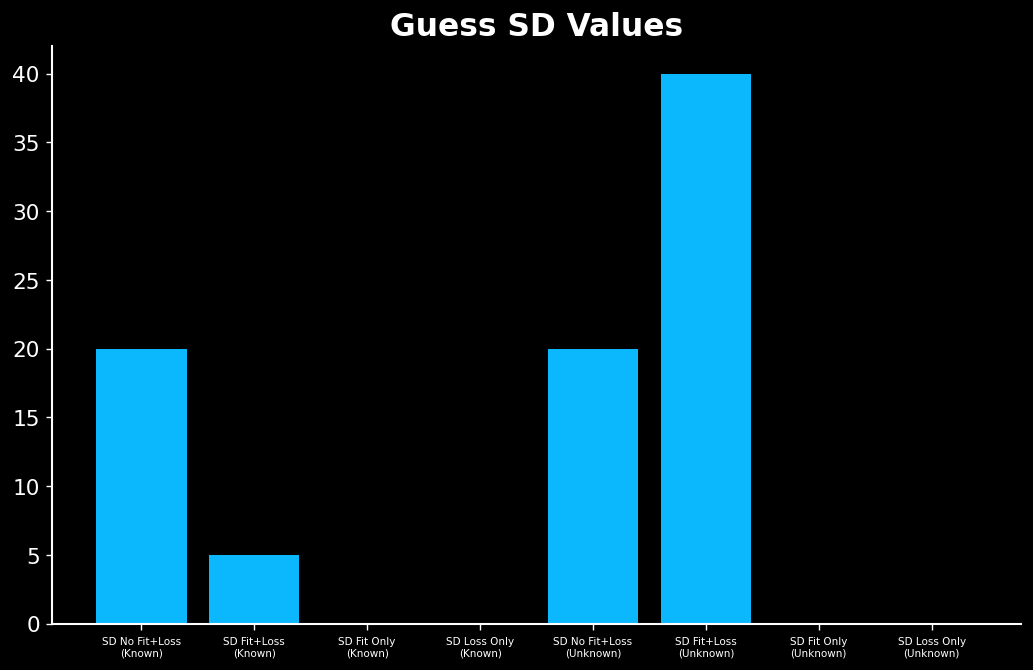

In [19]:
%matplotlib inline
metric = group.decision_metrics.player_stopping_times
no_switch_metric = model_no_switch.inputs.guess_switch_sd[0]
known_switch_sd_neither_metric   = model_known_switch_sd_neither.inputs.guess_switch_sd[0]
known_switch_sd_both_metric      = model_known_switch_sd_both.inputs.guess_switch_sd[0]
known_switch_sd_fit_metric       = model_known_switch_sd_fit.inputs.guess_switch_sd[0]
known_switch_sd_loss_metric      = model_known_switch_sd_loss.inputs.guess_switch_sd[0]
unknown_switch_sd_neither_metric = model_unknown_switch_sd_neither.inputs.guess_switch_sd[0]
unknown_switch_sd_both_metric    = model_unknown_switch_sd_both.inputs.guess_switch_sd[0]
unknown_switch_sd_fit_metric     = model_unknown_switch_sd_fit.inputs.guess_switch_sd[0]
unknown_switch_sd_loss_metric    = model_unknown_switch_sd_loss.inputs.guess_switch_sd[0]
known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
models = known_models+unknown_models
xlocs = np.arange(0,len(models),1)
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(xlocs, np.array(models).flatten())
ax.set_xticks(xlocs)
ax.set_xticklabels(all_model_labels,fontsize=6)
ax.set_title('Guess SD Values')
plt.show()

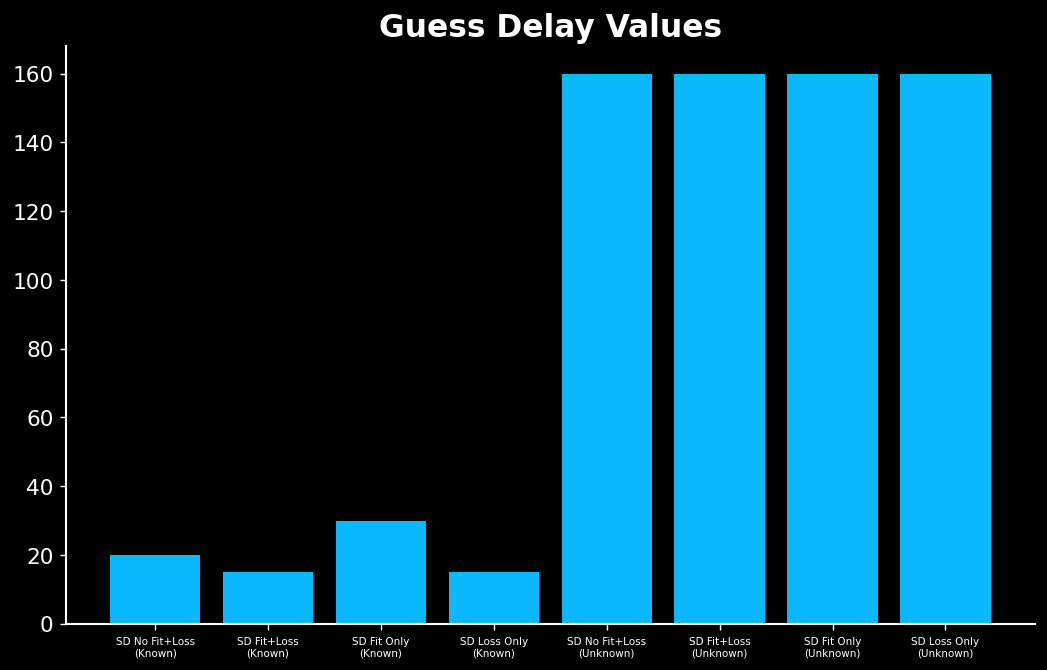

In [20]:
%matplotlib inline
metric = group.decision_metrics.player_stopping_times
no_switch_metric = model_no_switch.inputs.guess_switch_delay[0]
known_switch_sd_neither_metric   = model_known_switch_sd_neither.inputs.guess_switch_delay[0]
known_switch_sd_both_metric      = model_known_switch_sd_both.inputs.guess_switch_delay[0]
known_switch_sd_fit_metric       = model_known_switch_sd_fit.inputs.guess_switch_delay[0]
known_switch_sd_loss_metric      = model_known_switch_sd_loss.inputs.guess_switch_delay[0]
unknown_switch_sd_neither_metric = model_unknown_switch_sd_neither.inputs.guess_switch_delay[0]
unknown_switch_sd_both_metric    = model_unknown_switch_sd_both.inputs.guess_switch_delay[0]
unknown_switch_sd_fit_metric     = model_unknown_switch_sd_fit.inputs.guess_switch_delay[0]
unknown_switch_sd_loss_metric    = model_unknown_switch_sd_loss.inputs.guess_switch_delay[0]
known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
models = known_models+unknown_models
xlocs = np.arange(0,len(models),1)
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(xlocs, np.array(models).flatten())
ax.set_xticks(xlocs)
ax.set_xticklabels(all_model_labels,fontsize=6)
ax.set_title('Guess Delay Values')

plt.show()

In [21]:

if False:
    %matplotlib widget
    #* Set model fit object
    fit_object = model_fit_object_unknown

    if fit_object.parameter_arr.squeeze().ndim==1:
        plt.ioff()
        params = np.array(fit_object.parameter_arr)
        loss = fit_object.loss_store
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(params, loss)
        ax.set_xlabel('Guess Delay')
        ax.set_ylabel('Loss')
        ax.set_ylim(0,6)
        plt.show()
    else:
        plt.ion()
        params = np.array(fit_object.parameter_arr)
        loss = fit_object.loss_store
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(params[:,0], params[:,1], loss)
        ax.set_xlabel('Guess Delay')
        ax.set_ylabel('Guess SD')
        ax.set_xlim(0, 200)
        ax.set_ylim(0, 200)
        plt.show()

Plot movement onset vs guess delay

In [22]:
# %matplotlib inline
# yaxis_metric = model_fit_object_known.optimal_decision_time_store
# params = np.array(model_fit_object_known.parameter_arr[:,0])
# fig,axes = plt.subplots(2,3,figsize=(20,9),dpi=300)
# for i,ax in enumerate(axes.flatten()):
#     ax.scatter(params, yaxis_metric[:,i])
#     if i == 0 or i == 3:
#         ax.set_ylabel('Optimal Stopping Time (ms)')
#     if i>2:
#         ax.set_xlabel('Guess Switch Delay')
        
#     ax.axhline(behavior_targets.flatten()[i])
#     ax.axvline(model_known_switch.inputs.guess_switch_delay['true'],c='grey')
#     ax.set_yticks(np.arange(0,1600,250))
#     ax.set_ylim(500,1600)
#     if i == 4:
#         ax.set_ylim(0,1600)
#     ax.set_title(it.trial_block_titles[i])
    
# plt.show()

In [23]:
# %matplotlib inline
# yaxis_metric = model_fit_object_known.leave_time_store
# params = np.array(model_fit_object_known.parameter_arr[:,0])
# fig,axes = plt.subplots(2,3,figsize=(20,9),dpi=300)
# for i,ax in enumerate(axes.flatten()):
#     ax.scatter(params, yaxis_metric[:,i])
#     if i == 0 or i == 3:
#         ax.set_ylabel('Movement Onset Time (ms)')
#     if i>2:
#         ax.set_xlabel('Guess Switch Delay')
        
#     ax.axhline(behavior_targets.flatten()[i])
#     ax.axvline(model_known_switch.inputs.guess_switch_delay['true'],c='grey')
#     ax.set_yticks(np.arange(0,1600,250))
#     ax.set_ylim(500,1600)
#     if i == 4:
#         ax.set_ylim(0,1600)
#     ax.set_title(it.trial_block_titles[i])
    
# plt.show()

## Shorten the function names


In [24]:
get_no_switch_metric = model_no_switch.results.get_metric

get_known_switch_sd_neither_metric = model_known_switch_sd_neither.results.get_metric
get_known_switch_sd_both_metric    = model_known_switch_sd_both.results.get_metric
get_known_switch_sd_fit_metric     = model_known_switch_sd_fit.results.get_metric
get_known_switch_sd_loss_metric    = model_known_switch_sd_loss.results.get_metric

get_unknown_switch_sd_neither_metric = model_unknown_switch_sd_neither.results.get_metric
get_unknown_switch_sd_both_metric    = model_unknown_switch_sd_both.results.get_metric
get_unknown_switch_sd_fit_metric     = model_unknown_switch_sd_fit.results.get_metric
get_unknown_switch_sd_loss_metric    = model_unknown_switch_sd_loss.results.get_metric

In [25]:
# optimal_model_full_knowledge.plot_optimals(metrics = ['exp_reward','prob_making_given_reaction','prob_indecision_given_reaction','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_guess','prob_selecting_reaction'])

Predicted Decision Time


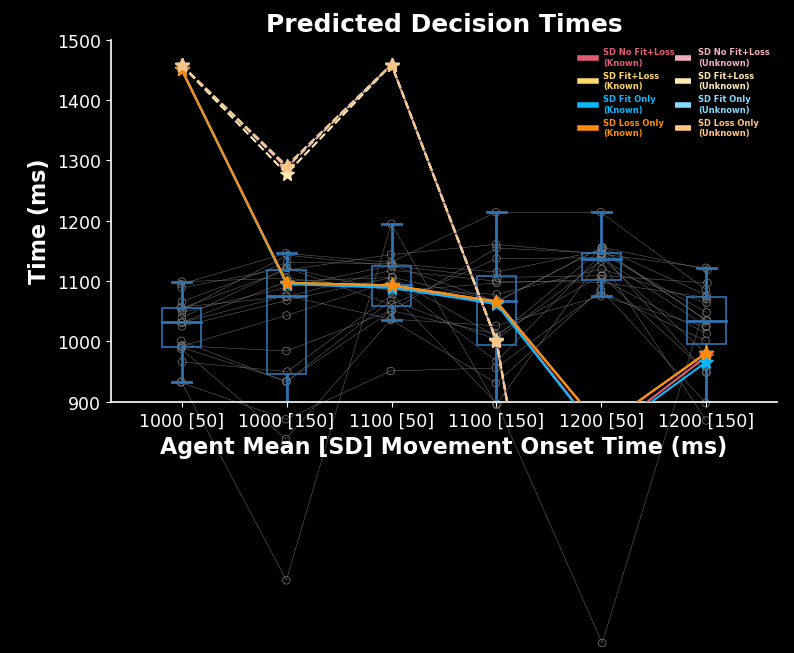

In [29]:
%matplotlib inline
metric = group.decision_metrics.player_stopping_times
no_switch_metric = model_no_switch.results.optimal_decision_time[0]
known_switch_sd_neither_metric   = model_known_switch_sd_neither.results.optimal_decision_time[0]
known_switch_sd_both_metric      = model_known_switch_sd_both.results.optimal_decision_time[0]
known_switch_sd_fit_metric       = model_known_switch_sd_fit.results.optimal_decision_time[0]
known_switch_sd_loss_metric      = model_known_switch_sd_loss.results.optimal_decision_time[0]
unknown_switch_sd_neither_metric = model_unknown_switch_sd_neither.results.optimal_decision_time[0]
unknown_switch_sd_both_metric    = model_unknown_switch_sd_both.results.optimal_decision_time[0]
unknown_switch_sd_fit_metric     = model_unknown_switch_sd_fit.results.optimal_decision_time[0]
unknown_switch_sd_loss_metric    = model_unknown_switch_sd_loss.results.optimal_decision_time[0]
known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
models = known_models+unknown_models

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=models,
    labels=all_model_labels,
    show_boxplot=True,
    xlocs=xlocs,
    ylocs = ylocs,
    xticklabels=it.trial_block_titles,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=None,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xlabel(it.xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Predicted Decision Times")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

LEave Target Time


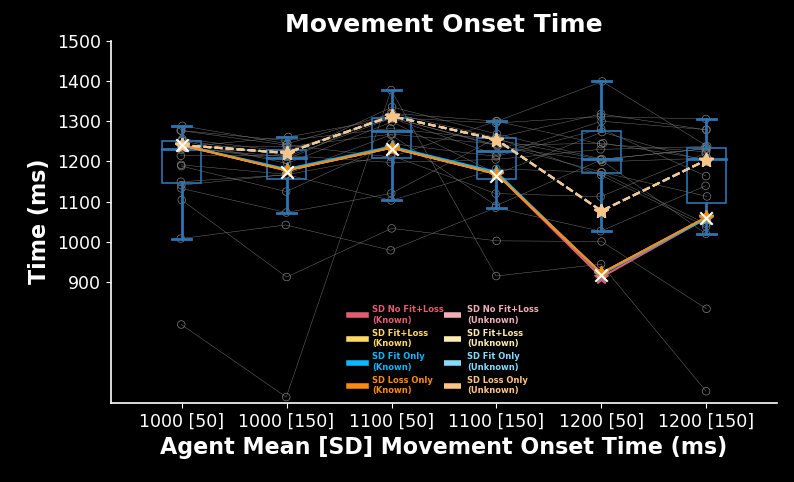

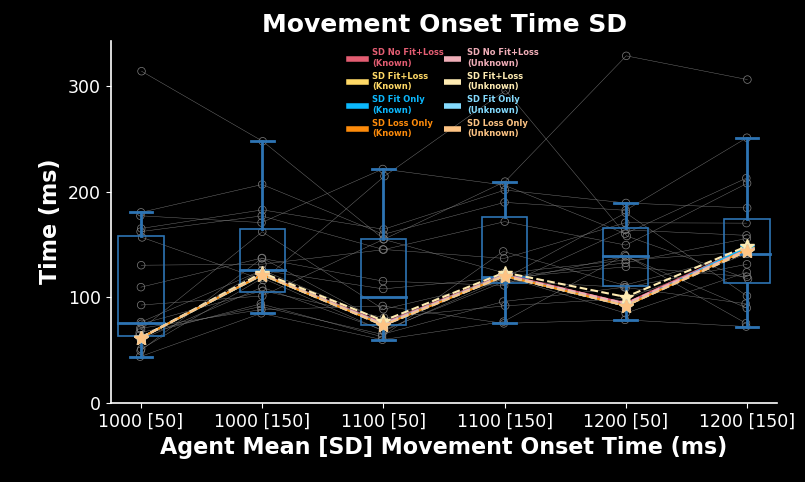

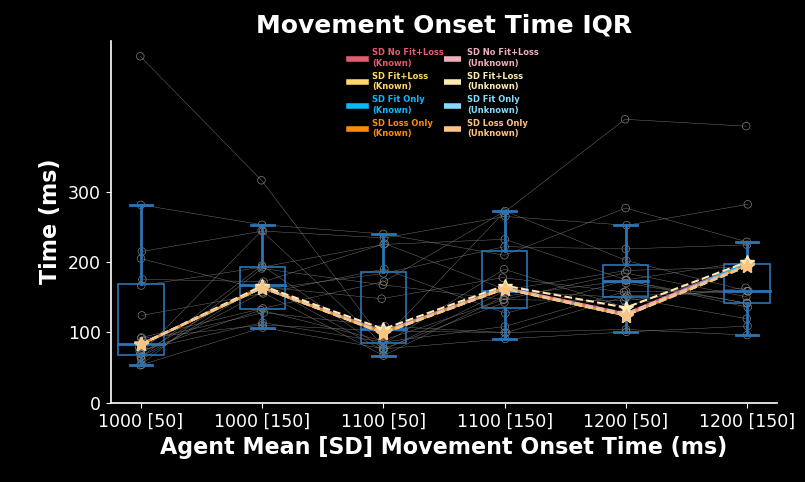

In [42]:
if True:
    metric = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
    no_switch_metric = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time,
                                            metric_type='true', decision_type='optimal') 
    known_switch_sd_neither_metric   = get_known_switch_sd_neither_metric(model_known_switch_sd_neither.player_behavior.wtd_leave_time,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_both_metric      = get_known_switch_sd_both_metric(model_known_switch_sd_both.player_behavior.wtd_leave_time,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_fit_metric       = get_known_switch_sd_fit_metric(model_known_switch_sd_fit.player_behavior.wtd_leave_time,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_loss_metric      = get_known_switch_sd_loss_metric(model_known_switch_sd_loss.player_behavior.wtd_leave_time,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_neither_metric = get_unknown_switch_sd_neither_metric(model_unknown_switch_sd_neither.player_behavior.wtd_leave_time,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_both_metric    = get_unknown_switch_sd_both_metric(model_unknown_switch_sd_both.player_behavior.wtd_leave_time,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_fit_metric     = get_unknown_switch_sd_fit_metric(model_unknown_switch_sd_fit.player_behavior.wtd_leave_time,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_loss_metric    = get_unknown_switch_sd_loss_metric(model_unknown_switch_sd_loss.player_behavior.wtd_leave_time,
                                                                          metric_type='true', decision_type='optimal') 
    known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
    unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
    models = known_models+unknown_models
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(900, 1600, 100)
    pf.multiple_models_boxplot_v2(
        ax=ax,
        data=metric,
        model_data_list=models,
        labels=all_model_labels,
        show_boxplot=True,
        xlocs=xlocs,
        ylocs=ylocs,
        box_width=0.75,
        colors=wheel.seth_blue,
        linestyles=None,
        xticklabels=it.trial_block_titles,    
        xlabel= it.xlabel, 
        ylabel = "Time (ms)",
        title = "Movement Onset Time"    
    )
    ax.scatter(np.linspace(0, w, num=len(it.trial_block_titles)), no_switch_metric, color='white',zorder=900,marker='x',s=80)
    ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
    ax.set_ylim(600, max(ylocs))
    if save:
        plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
    axmain.set_axis_off()
    plt.show()

##########################################
if True:
    metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
    
    known_switch_sd_neither_metric   = get_known_switch_sd_neither_metric(model_known_switch_sd_neither.player_behavior.wtd_leave_time_sd,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_both_metric      = get_known_switch_sd_both_metric(model_known_switch_sd_both.player_behavior.wtd_leave_time_sd,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_fit_metric       = get_known_switch_sd_fit_metric(model_known_switch_sd_fit.player_behavior.wtd_leave_time_sd,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_loss_metric      = get_known_switch_sd_loss_metric(model_known_switch_sd_loss.player_behavior.wtd_leave_time_sd,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_neither_metric = get_unknown_switch_sd_neither_metric(model_unknown_switch_sd_neither.player_behavior.wtd_leave_time_sd,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_both_metric    = get_unknown_switch_sd_both_metric(model_unknown_switch_sd_both.player_behavior.wtd_leave_time_sd,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_fit_metric     = get_unknown_switch_sd_fit_metric(model_unknown_switch_sd_fit.player_behavior.wtd_leave_time_sd,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_loss_metric    = get_unknown_switch_sd_loss_metric(model_unknown_switch_sd_loss.player_behavior.wtd_leave_time_sd,
                                                                          metric_type='true', decision_type='optimal') 
    known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
    unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
    models = known_models+unknown_models
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
    pf.multiple_models_boxplot_v2(
        ax=ax,
        data=metric,
        model_data_list=models,
        labels=all_model_labels,
        show_boxplot=True,
        xlocs=np.linspace(0, w, num=len(it.trial_block_titles)),
        ylocs=np.arange(0, 400, 100),
        box_width=0.75,
        colors=wheel.seth_blue,
        linestyles=None,
        xticklabels=it.trial_block_titles,    
        xlabel= it.xlabel, 
        ylabel = "Time (ms)",
        title = "Movement Onset Time SD"    
    )
    # ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
    # ax.set_ylim(600, max(ylocs))
    if save:
        plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
    axmain.set_axis_off()
    plt.show()

###################################
if True:
    metric = iqr(group.movement_metrics.movement_onset_times('task'), axis=2)
    
    known_switch_sd_neither_metric   = get_known_switch_sd_neither_metric(model_known_switch_sd_neither.player_behavior.wtd_leave_time_iqr,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_both_metric      = get_known_switch_sd_both_metric(model_known_switch_sd_both.player_behavior.wtd_leave_time_iqr,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_fit_metric       = get_known_switch_sd_fit_metric(model_known_switch_sd_fit.player_behavior.wtd_leave_time_iqr,
                                                                          metric_type='true', decision_type='optimal') 
    known_switch_sd_loss_metric      = get_known_switch_sd_loss_metric(model_known_switch_sd_loss.player_behavior.wtd_leave_time_iqr,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_neither_metric = get_unknown_switch_sd_neither_metric(model_unknown_switch_sd_neither.player_behavior.wtd_leave_time_iqr,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_both_metric    = get_unknown_switch_sd_both_metric(model_unknown_switch_sd_both.player_behavior.wtd_leave_time_iqr,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_fit_metric     = get_unknown_switch_sd_fit_metric(model_unknown_switch_sd_fit.player_behavior.wtd_leave_time_iqr,
                                                                          metric_type='true', decision_type='optimal') 
    unknown_switch_sd_loss_metric    = get_unknown_switch_sd_loss_metric(model_unknown_switch_sd_loss.player_behavior.wtd_leave_time_iqr,
                                                                          metric_type='true', decision_type='optimal') 
    known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
    unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
    models = known_models+unknown_models
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
    pf.multiple_models_boxplot_v2(
        ax=ax,
        data=metric,
        model_data_list=models,
        labels=all_model_labels,
        show_boxplot=True,
        xlocs=np.linspace(0, w, num=len(it.trial_block_titles)),
        ylocs=np.arange(0, 400, 100),
        box_width=0.75,
        colors=wheel.seth_blue,
        linestyles=None,
        xticklabels=it.trial_block_titles,    
        xlabel= it.xlabel, 
        ylabel = "Time (ms)",
        title = "Movement Onset Time IQR"    
    )
    # ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
    # ax.set_ylim(600, max(ylocs))
    if save:
        plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
    axmain.set_axis_off()
    plt.show()

Wins


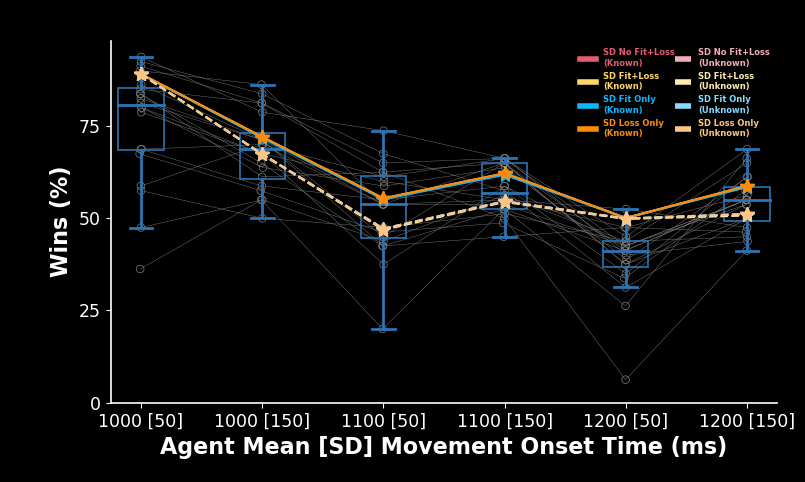

In [ ]:
metric = perc(group.score_metrics.score_metric('wins'))

no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.prob_win,decision_type='optimal')*100
known_switch_sd_neither_metric   = get_known_switch_sd_neither_metric(model_known_switch_sd_neither.score_metrics.prob_win,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_both_metric      = get_known_switch_sd_both_metric(model_known_switch_sd_both.score_metrics.prob_win,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_fit_metric       = get_known_switch_sd_fit_metric(model_known_switch_sd_fit.score_metrics.prob_win,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_loss_metric      = get_known_switch_sd_loss_metric(model_known_switch_sd_loss.score_metrics.prob_win,
                                                                        metric_type='true', decision_type='optimal')*100
unknown_switch_sd_neither_metric = get_unknown_switch_sd_neither_metric(model_unknown_switch_sd_neither.score_metrics.prob_win,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_both_metric    = get_unknown_switch_sd_both_metric(model_unknown_switch_sd_both.score_metrics.prob_win,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_fit_metric     = get_unknown_switch_sd_fit_metric(model_unknown_switch_sd_fit.score_metrics.prob_win,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_loss_metric    = get_unknown_switch_sd_loss_metric(model_unknown_switch_sd_loss.score_metrics.prob_win,
                                                                        metric_type='true', decision_type='optimal')*100 
known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
models = known_models+unknown_models
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=models,
    labels=all_model_labels,
    show_boxplot=True,
    xlocs=np.linspace(0, w, num=len(it.trial_block_titles)),
    ylocs=np.arange(0, 101, 25),
    box_width=0.75,
    colors=wheel.seth_blue,
    linestyles=None,
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Wins (%)",
    title = None    
)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(600, max(ylocs))
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "wins_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Points


In [ ]:
if experiment == "Exp2":
    metric = group.player_points_scored
    true_player_metric = get_true_metric(model_known_switch.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    exp_player_metric = get_exp_metric(model_unknown.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    true_optimal_metric = get_true_metric(model_known_switch.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    exp_optimal_metric = get_exp_metric(model_known_switch.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(0, 125, 20)

    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        true_player=true_player_metric,
        expected_player=exp_player_metric,
        true_optimal=true_optimal_metric,
        expected_optimal=exp_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.seth_blue,
        remove_parentheses_from_labels=False,
    )

    ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(it.trial_block_titles)
    ax.set_ylim(-20, 80)
    ax.set_xlabel(it.xlabel)
    ax.set_ylabel("Points Scored")
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
    axmain.set_axis_off()

    plt.show()

Incorrects


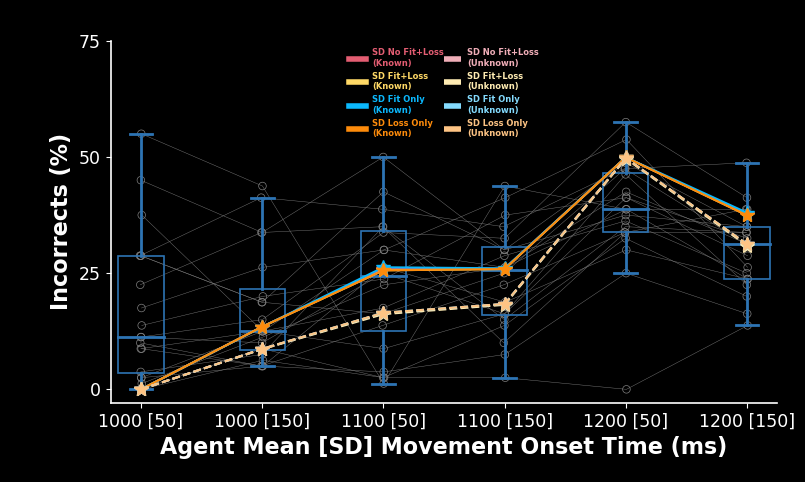

In [ ]:
metric = perc(group.score_metrics.score_metric('incorrects'))

no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.prob_incorrect,decision_type='optimal')*100
known_switch_sd_neither_metric   = get_known_switch_sd_neither_metric(model_known_switch_sd_neither.score_metrics.prob_incorrect,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_both_metric      = get_known_switch_sd_both_metric(model_known_switch_sd_both.score_metrics.prob_incorrect,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_fit_metric       = get_known_switch_sd_fit_metric(model_known_switch_sd_fit.score_metrics.prob_incorrect,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_loss_metric      = get_known_switch_sd_loss_metric(model_known_switch_sd_loss.score_metrics.prob_incorrect,
                                                                        metric_type='true', decision_type='optimal')*100
unknown_switch_sd_neither_metric = get_unknown_switch_sd_neither_metric(model_unknown_switch_sd_neither.score_metrics.prob_incorrect,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_both_metric    = get_unknown_switch_sd_both_metric(model_unknown_switch_sd_both.score_metrics.prob_incorrect,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_fit_metric     = get_unknown_switch_sd_fit_metric(model_unknown_switch_sd_fit.score_metrics.prob_incorrect,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_loss_metric    = get_unknown_switch_sd_loss_metric(model_unknown_switch_sd_loss.score_metrics.prob_incorrect,
                                                                        metric_type='true', decision_type='optimal')*100 
known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
models = known_models+unknown_models
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=models,
    labels=all_model_labels,
    show_boxplot=True,
    xlocs=np.linspace(0, w, num=len(it.trial_block_titles)),
    ylocs=np.arange(0, 101, 25),
    box_width=0.75,
    colors=wheel.seth_blue,
    linestyles=None,
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Incorrects (%)",
    title = None    
)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(600, max(ylocs))
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Indecisions


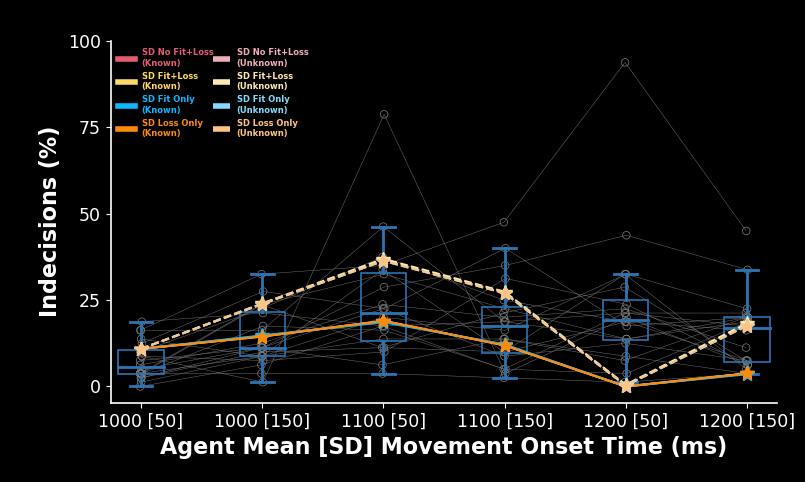

In [ ]:
metric = perc(group.score_metrics.score_metric('indecisions'))

no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.prob_indecision,decision_type='optimal')*100
known_switch_sd_neither_metric   = get_known_switch_sd_neither_metric(model_known_switch_sd_neither.score_metrics.prob_indecision,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_both_metric      = get_known_switch_sd_both_metric(model_known_switch_sd_both.score_metrics.prob_indecision,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_fit_metric       = get_known_switch_sd_fit_metric(model_known_switch_sd_fit.score_metrics.prob_indecision,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_loss_metric      = get_known_switch_sd_loss_metric(model_known_switch_sd_loss.score_metrics.prob_indecision,
                                                                        metric_type='true', decision_type='optimal')*100
unknown_switch_sd_neither_metric = get_unknown_switch_sd_neither_metric(model_unknown_switch_sd_neither.score_metrics.prob_indecision,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_both_metric    = get_unknown_switch_sd_both_metric(model_unknown_switch_sd_both.score_metrics.prob_indecision,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_fit_metric     = get_unknown_switch_sd_fit_metric(model_unknown_switch_sd_fit.score_metrics.prob_indecision,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_loss_metric    = get_unknown_switch_sd_loss_metric(model_unknown_switch_sd_loss.score_metrics.prob_indecision,
                                                                        metric_type='true', decision_type='optimal')*100 
known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
models = known_models+unknown_models
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=models,
    labels=all_model_labels,
    show_boxplot=True,
    xlocs=np.linspace(0, w, num=len(it.trial_block_titles)),
    ylocs=np.arange(0, 101, 25),
    box_width=0.75,
    colors=wheel.seth_blue,
    linestyles=None,
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Indecisions (%)",
    title = None    
)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(600, max(ylocs))
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "indecisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Correct Initial Decisions


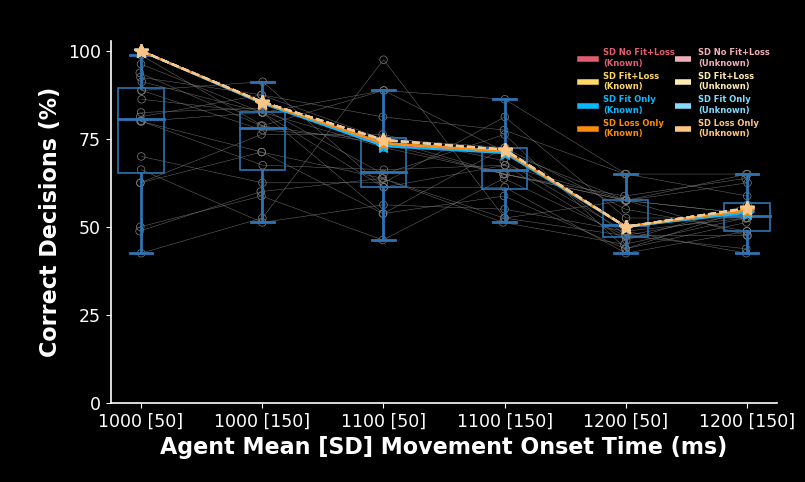

In [ ]:
metric = perc(group.movement_metrics.correct_initial_decisions)

no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.correct_decisions,decision_type='optimal')*100
known_switch_sd_neither_metric   = get_known_switch_sd_neither_metric(model_known_switch_sd_neither.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_both_metric      = get_known_switch_sd_both_metric(model_known_switch_sd_both.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_fit_metric       = get_known_switch_sd_fit_metric(model_known_switch_sd_fit.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_loss_metric      = get_known_switch_sd_loss_metric(model_known_switch_sd_loss.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100
unknown_switch_sd_neither_metric = get_unknown_switch_sd_neither_metric(model_unknown_switch_sd_neither.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_both_metric    = get_unknown_switch_sd_both_metric(model_unknown_switch_sd_both.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_fit_metric     = get_unknown_switch_sd_fit_metric(model_unknown_switch_sd_fit.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_loss_metric    = get_unknown_switch_sd_loss_metric(model_unknown_switch_sd_loss.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
models = known_models+unknown_models
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=models,
    labels=all_model_labels,
    show_boxplot=True,
    xlocs=np.linspace(0, w, num=len(it.trial_block_titles)),
    ylocs=np.arange(0, 101, 25),
    box_width=0.75,
    colors=wheel.seth_blue,
    linestyles=None,
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Correct Decisions (%)",
    title = None    
)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(600, max(ylocs))
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "correct_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Decisions


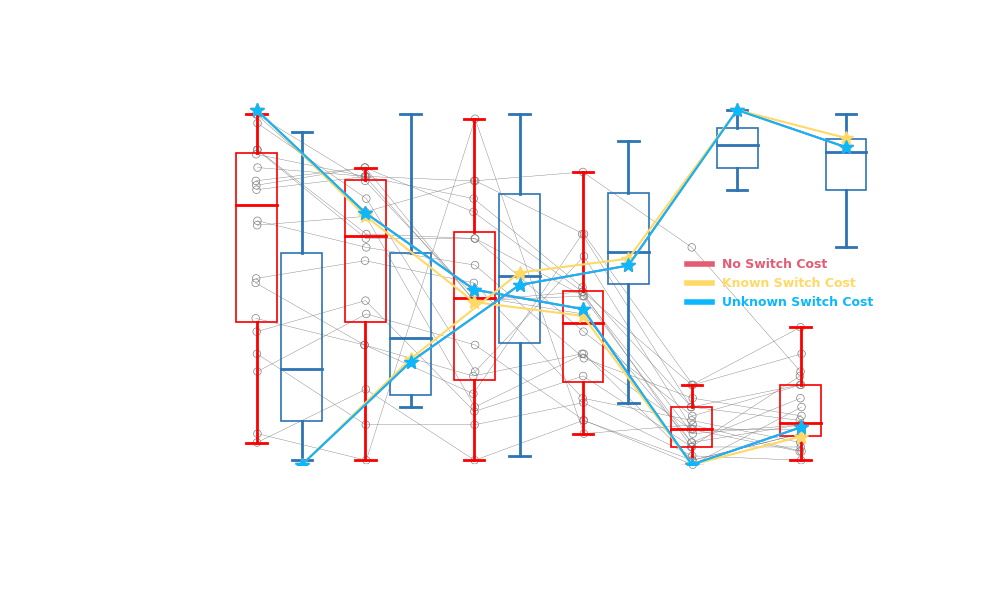

In [ ]:
data_metric1 = group.react_guess_score_metrics.react_guess_decisions('react')/it.num_trials*100
no_switch_metric1 = get_no_switch_metric(model_no_switch.player_behavior.prob_selecting_reaction, 
                                        metric_type='true',decision_type="optimal") * 100
switch_metric1 = get_known_switch_metric(model_known_switch.player_behavior.prob_selecting_reaction, 
                                        metric_type='true',decision_type="optimal") * 100
unknown_switch_metric1 = get_no_switch_metric(model_known_switch.player_behavior.prob_selecting_reaction, 
                                        metric_type='true',decision_type="optimal") * 100

data_metric2 = group.react_guess_score_metrics.react_guess_decisions('guess')/it.num_trials*100
no_switch_metric2 = get_no_switch_metric(model_no_switch.player_behavior.prob_selecting_guess, 
                                        metric_type='true',decision_type="optimal") * 100
switch_metric2 = get_known_switch_metric(model_known_switch.player_behavior.prob_selecting_guess, 
                                        metric_type='true',decision_type="optimal") * 100
unknown_switch_metric2 = get_no_switch_metric(model_known_switch.player_behavior.prob_selecting_guess, 
                                        metric_type='true',decision_type="optimal") * 100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Decisions")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Leave Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


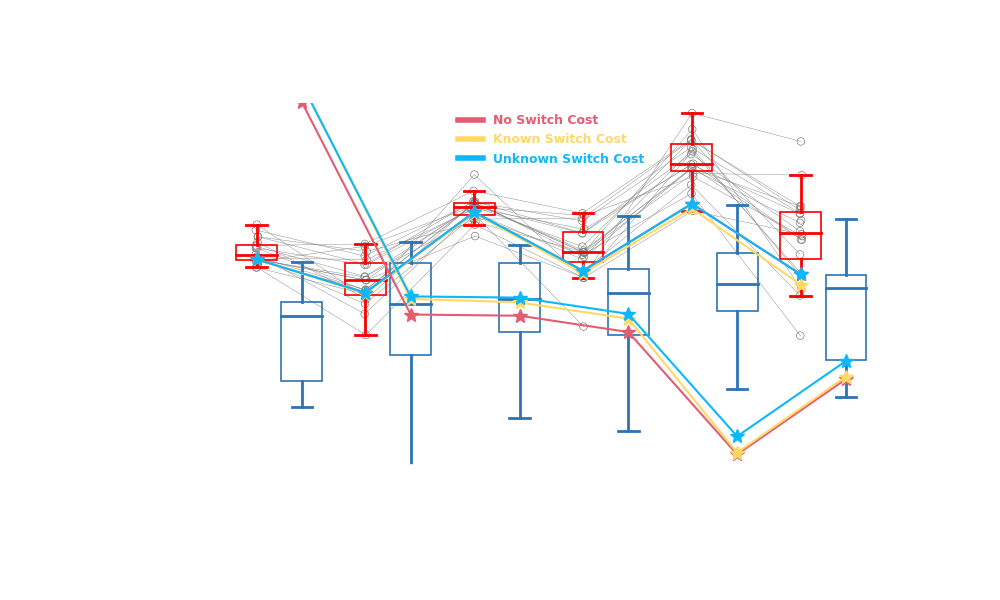

In [ ]:
data_metric1 = np.nanmedian(group.react_guess_movement_metrics.movement_onset_times('react'), axis=2)
data_metric2 = np.nanmedian(group.react_guess_movement_metrics.movement_onset_times('guess'), axis=2)


no_switch_metric1 = get_no_switch_metric(model_no_switch.player_behavior.reaction_leave_time, 
                                            metric_type='true',decision_type="optimal")
switch_metric1 = get_known_switch_metric(model_known_switch.player_behavior.reaction_leave_time, 
                                            metric_type='true',decision_type="optimal")
unknown_switch_metric1 = get_no_switch_metric(model_known_switch.player_behavior.reaction_leave_time, 
                                            metric_type='true',decision_type="optimal")

no_switch_metric2 = get_no_switch_metric(model_no_switch.player_behavior.guess_leave_time, 
                                            metric_type='true',decision_type="optimal")
switch_metric2 = get_known_switch_metric(model_known_switch.player_behavior.guess_leave_time, 
                                            metric_type='true',decision_type="optimal")
unknown_switch_metric2 = get_no_switch_metric(model_known_switch.player_behavior.guess_leave_time, 
                                            metric_type='true',decision_type="optimal")

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1650, 150)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Movement Onset Times")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Guess Movement Onset Times


In [ ]:
data_metric1 = np.nanmedian(group.agent_reaction_task_leave_time, axis=2)
data_metric2 = np.nanmedian(group.agent_guess_task_leave_time, axis=2)

no_switch_metric1 = get_no_switch_metric(model_no_switch.agent_behavior.reaction_leave_time, metric_type="optimal")
switch_metric1 = get_known_switch_metric(model_known_switch.agent_behavior.reaction_leave_time, metric_type="optimal")
unknown_switch_metric1 = get_no_switch_metric(model_known_switch.agent_behavior.reaction_leave_time, metric_type="optimal")

no_switch_metric2 = get_no_switch_metric(model_no_switch.agent_behavior.guess_leave_time, metric_type="optimal")
switch_metric2 = get_known_switch_metric(model_known_switch.agent_behavior.guess_leave_time, metric_type="optimal")
unknown_switch_metric2 = get_no_switch_metric(model_known_switch.agent_behavior.guess_leave_time, metric_type="optimal")

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1650, 150)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4jj,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Agent Movement Onset Times")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

AttributeError: 'SubjectBuilder' object has no attribute 'agent_reaction_task_leave_time'

Wins That Were Reaction and guess

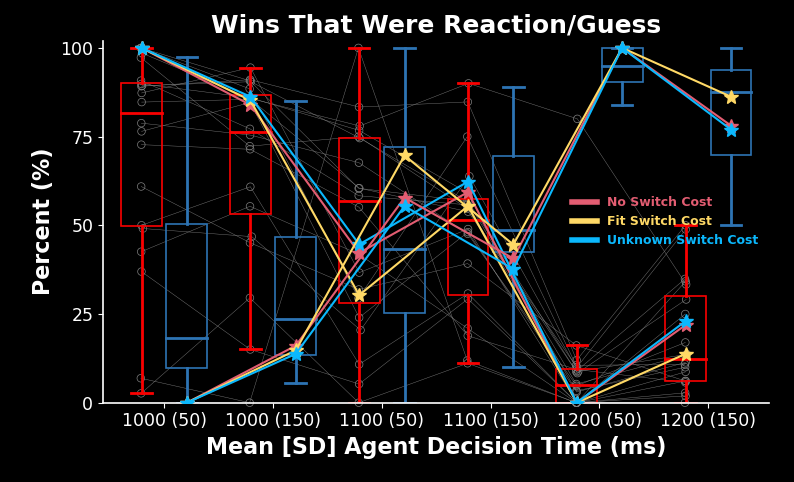

In [ ]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.perc_wins_that_were_reactions
data_metric2 = group.perc_wins_that_were_guesss

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_win_reaction, 
    model_no_switch.score_metrics.prob_win, metric_type="optimal"
) * 100
switch_metric1 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_win_reaction, 
    model_known_switch.score_metrics.prob_win, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_win_reaction, 
    model_known_switch.score_metrics.prob_win, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_win_guess, 
    model_no_switch.score_metrics.prob_win, metric_type="optimal"
) * 100
switch_metric2 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_win_guess, 
    model_known_switch.score_metrics.prob_win, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_win_guess, 
    model_known_switch.score_metrics.prob_win, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Wins That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Incorrects that were Reaction and Guess


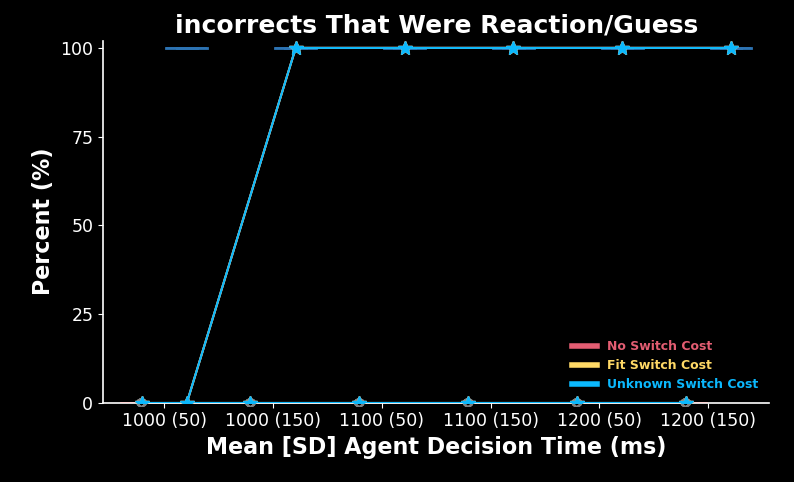

In [ ]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.perc_incorrects_that_were_reactions
data_metric2 = group.perc_incorrects_that_were_guesss

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_incorrect_reaction, 
    model_no_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
switch_metric1 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_reaction, 
    model_known_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_reaction, 
    model_known_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_incorrect_guess, 
    model_no_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
switch_metric2 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_guess, 
    model_known_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_guess, 
    model_known_switch.score_metrics.prob_incorrect, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("incorrects That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Reaction/guess


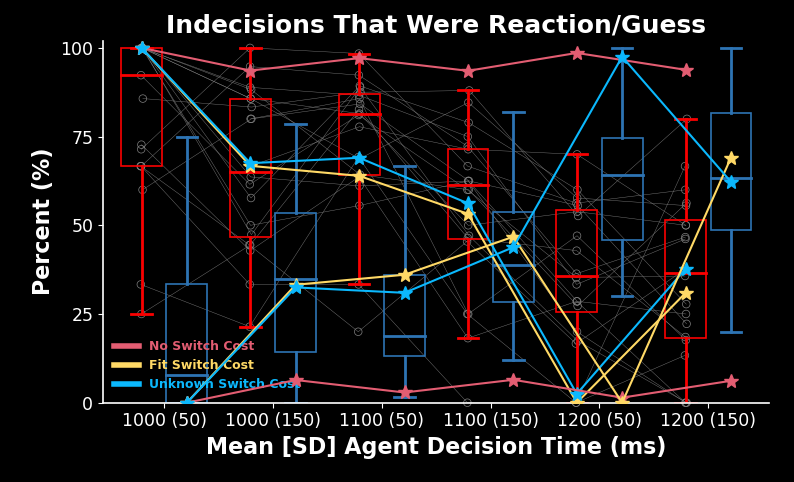

In [ ]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.perc_indecisions_that_were_reactions
data_metric2 = group.perc_indecisions_that_were_guesss

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_indecision_reaction, 
    model_no_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
switch_metric1 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_indecision_reaction, 
    model_known_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_indecision_reaction, 
    model_known_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_indecision_guess, 
    model_no_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
switch_metric2 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_indecision_guess, 
    model_known_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_indecision_guess, 
    model_known_switch.score_metrics.prob_indecision, metric_type="optimal"
) * 100
# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Indecisions That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/guess How many times did they win


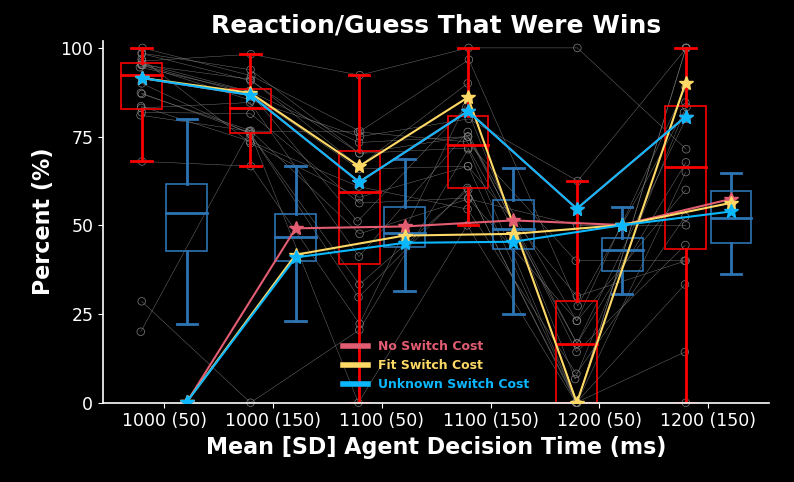

In [ ]:
#
# * Out of x number of reactions/guesss, how many were wins
data_metric1 = group.perc_reactions_that_were_wins
data_metric2 = group.perc_guesss_that_were_wins

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_win_reaction, 
    model_no_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
switch_metric1 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_win_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_win_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_win_guess, 
    model_no_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100
switch_metric2 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_win_guess, 
    model_known_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_win_guess, 
    model_known_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Wins")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Reaction and Guess That Were Incorrects


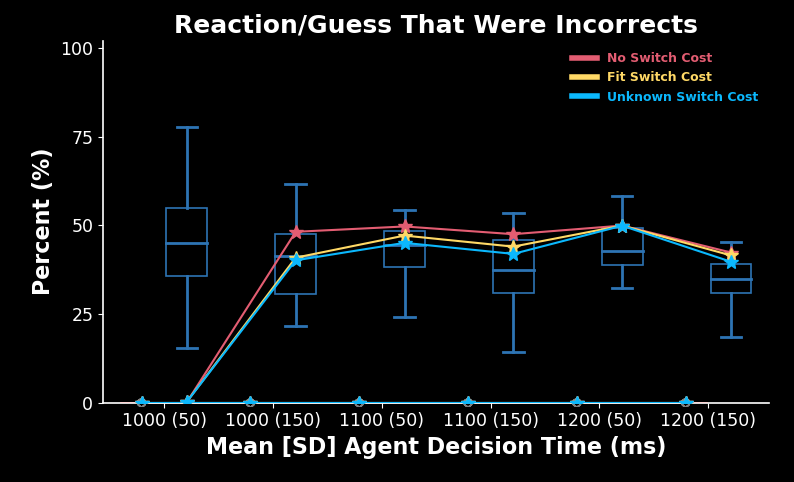

In [ ]:
#
# * Out of x number of reactions/guesss, how many were incorrects
data_metric1 = group.perc_reactions_that_were_incorrects
data_metric2 = group.perc_guesss_that_were_incorrects

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_incorrect_reaction, 
    model_no_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
switch_metric1 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_incorrect_guess, 
    model_no_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100
switch_metric2 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_guess, 
    model_known_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_incorrect_guess, 
    model_known_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Incorrects")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

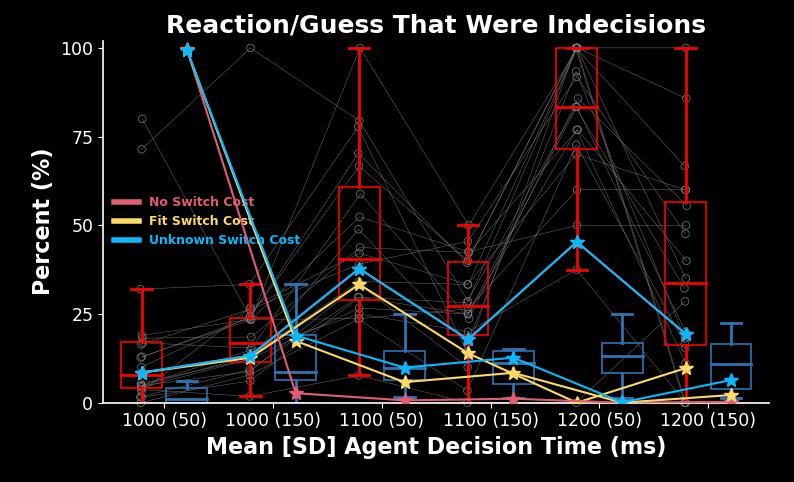

In [ ]:
#
# * Out of x number of reactions/guesss, how many were indecisions
data_metric1 = group.perc_reactions_that_were_indecisions
data_metric2 = group.perc_guesss_that_were_indecisions

no_switch_metric1 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_indecision_reaction, 
    model_no_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
switch_metric1 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_indecision_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_indecision_reaction, 
    model_known_switch.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_no_switch.score_metrics.prob_indecision_guess, 
    model_no_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100
switch_metric2 = get_known_switch_metric(
    model_known_switch.score_metrics.prob_indecision_guess, 
    model_known_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_known_switch.score_metrics.prob_indecision_guess, 
    model_known_switch.player_behavior.prob_selecting_guess, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[no_switch_metric1, switch_metric1, unknown_switch_metric1],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2, unknown_switch_metric2],
    labels=['No Switch Cost','Known Switch Cost','Unknown Switch Cost'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Indecisions")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()